In [1]:
#run15 - 14/08 - Modified ROC/AUC code
#run14 - 13/08 - Added ROC/AUC and epoch graph
#run13 - 12/08 - Include good and noisy images in training
#run10 - 10/08 - Added more train and validation images
#run8 - 09/08 - Remove checkpointing; Modify code for 3 categories only; Set seed value to obtain uniform results
#run7 - 26/07 - Add metrics for precision and recall; Add try/catch; Add checkpoint; Code modified for all categories

In [2]:
from numpy.random import seed
seed(30)
from tensorflow import set_random_seed
set_random_seed(333)


In [3]:
from keras.applications import VGG16

Using TensorFlow backend.


In [4]:
from keras import models
from keras import layers
from keras import optimizers
import os
from keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras import metrics
from matplotlib import pyplot as plt
from keras.models import load_model

In [5]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [6]:
#lOAD VGG MODEL

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [7]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

In [8]:
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000076F4B43A58> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4B96B70> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4B96DD8> False
<keras.layers.pooling.MaxPooling2D object at 0x00000076F4B96A58> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4BA3518> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4BE6EB8> False
<keras.layers.pooling.MaxPooling2D object at 0x00000076F4C09CC0> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4C09FD0> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4BF3D30> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4C31E10> False
<keras.layers.pooling.MaxPooling2D object at 0x00000076F4C41668> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4C635F8> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4C63710> False
<keras.layers.convolutional.Conv2D object at 0x00000076F4C8C9B0> False
<ker

In [9]:
# Create the model
model = models.Sequential()

In [10]:
# Add the vgg convolutional base model
model.add(vgg_conv)

In [11]:
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [12]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 40,408,899
Trainable params: 32,773,635
Non-trainable params: 7,635,264
_________________________________________________________________


In [13]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [14]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
os.chdir("your path here")
fileDir = os.path.dirname(os.path.realpath('__file__'))

In [17]:
train_dir = os.path.join(fileDir,'dataset\\train')
validation_dir = os.path.join(fileDir,'dataset\\validation')

In [18]:
# Change the batchsize according to your system RAM
train_batchsize = 10
val_batchsize = 5
image_size =224

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical',
        shuffle=False)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 30 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [19]:
no_of_epochs=1

# Save the checkpoint in the /output folder
filepath = "your path\\final.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max',
                            period=no_of_epochs)


In [20]:
# Compile the model

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.00001),
              metrics=['acc'])

In [21]:
# Train the model

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size ,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    verbose=1,
    callbacks=[checkpoint])


Epoch 1/5
3/3 [==============================] - 36s 12s/step - loss: 2.1227 - acc: 0.0667 - val_loss: 1.2018 - val_acc: 0.3333

Epoch 00001: val_acc improved from -inf to 0.33333, saving model to D:\GLIM\CAPSTONE\Algo\final.hdf5
Epoch 2/5
3/3 [==============================] - 35s 12s/step - loss: 1.4705 - acc: 0.1333 - val_loss: 1.0432 - val_acc: 0.3333

Epoch 00002: val_acc improved from 0.33333 to 0.33333, saving model to D:\GLIM\CAPSTONE\Algo\final.hdf5
Epoch 3/5
3/3 [==============================] - 35s 12s/step - loss: 1.2294 - acc: 0.3667 - val_loss: 0.9274 - val_acc: 0.6667

Epoch 00003: val_acc improved from 0.33333 to 0.66667, saving model to D:\GLIM\CAPSTONE\Algo\final.hdf5
Epoch 4/5
3/3 [==============================] - 40s 13s/step - loss: 1.1290 - acc: 0.3000 - val_loss: 0.8736 - val_acc: 0.6667

Epoch 00004: val_acc did not improve from 0.66667
Epoch 5/5
3/3 [==============================] - 44s 15s/step - loss: 1.1596 - acc: 0.2333 - val_loss: 0.8042 - val_acc: 0.86

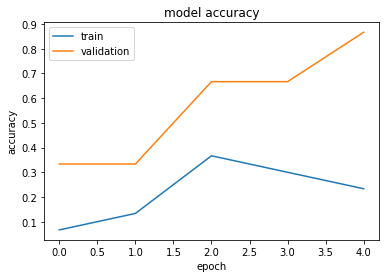

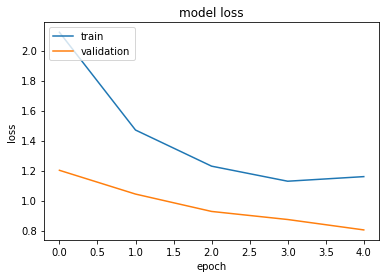

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
model.save(os.path.join(fileDir,'model_fc_1508_run15_cat3.h5'))
model.save(filepath)

In [24]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
probs = model.predict_generator(validation_generator, validation_generator.samples/validation_generator.batch_size)
iscat = probs[:,0]
y_hat = np.round(1-iscat)
y     = validation_generator.classes
n_classes=len(np.unique(y))

In [26]:
y_array = np.ones(shape = (len(y),len(np.unique(y))))
y_array.fill(0)
for idx, val in enumerate(y):
    y_array[idx,val]=1

In [27]:
y_pred=probs

In [28]:
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_array[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [29]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_array.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

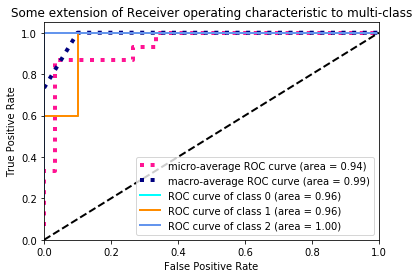

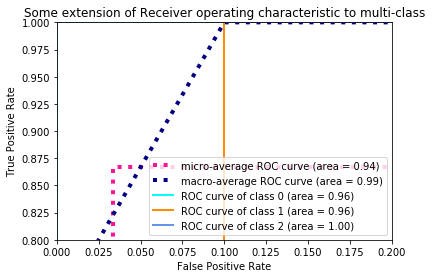

In [32]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [33]:
#confusion matrix for validation set

from sklearn.metrics import classification_report
Y_pred = model.predict_generator(validation_generator, validation_generator.samples/validation_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['bed','chair','cupboard'] #<------ Provide all classes in the order that need to be predicted
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[5 0 0]
 [2 3 0]
 [0 0 5]]
Classification Report
             precision    recall  f1-score   support

        bed       0.71      1.00      0.83         5
      chair       1.00      0.60      0.75         5
   cupboard       1.00      1.00      1.00         5

avg / total       0.90      0.87      0.86        15

